<a href="https://colab.research.google.com/github/ishancoderr/GANs/blob/main/GANS_010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to generative adversarial networks**

*Generator network—Takes as input a random vector (a random point in the
latent space), and decodes it into a synthetic image

*Discriminator network (or adversary)—Takes as input an image (real or synthetic),
and predicts whether the image came from the training set or was created by
the generator network.

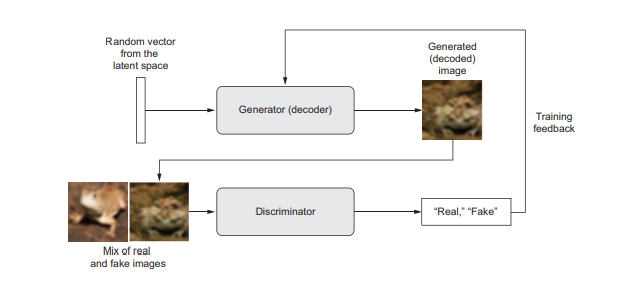

***The generator***

In [4]:
import keras
from keras import layers
import numpy as np
latent_dim = 32
height = 32
width = 32
channels = 3

In [9]:
generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 256)      1048

In [12]:
import tensorflow as tf
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()
discriminator_optimizer =tf.keras.optimizers.RMSprop(
 lr=0.0008,
 clipvalue=1.0,
 decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
loss='binary_crossentropy')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 6, 6, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [13]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = tf.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [25]:
import os
from keras.preprocessing import image
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

In [26]:
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
(x_train.shape[0],) +
(height, width, channels)).astype('float32') / 255.
iterations = 10000
batch_size = 20
save_dir = 'your_dir'
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size, 1)),
  np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  d_loss = discriminator.train_on_batch(combined_images, labels)
  random_latent_vectors = np.random.normal(size=(batch_size,
  latent_dim))
  misleading_targets = np.zeros((batch_size, 1))
  a_loss = gan.train_on_batch(random_latent_vectors,misleading_targets)
  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print('discriminator loss:', d_loss)
    print('adversarial loss:', a_loss)

    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join('/content/sample_data','generated_frog' + str(step) + '.png'))
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join('/content/sample_data','real_frog' + str(step) + '.png'))

discriminator loss: 6.652288913726807
adversarial loss: 0.9412247538566589
discriminator loss: 0.6953996419906616
adversarial loss: 0.9809229969978333
discriminator loss: 0.7694391012191772
adversarial loss: 0.6585982441902161
discriminator loss: 0.6802166104316711
adversarial loss: 0.854546070098877


KeyboardInterrupt: ignored